# Chatty the chatterbox

## Import Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2.3.0


### Create Directories for data, results and models

In [2]:
!pwd
!mkdir ../results
!mkdir ../data
!mkdir ../models


/content


###Steps for google colab to copy data file to desired directory


In [3]:
!cp sample_data/chats.txt ../data/chats.txt


In [4]:
!ls -l /data/chats.txt

-rw-r--r-- 1 root root 1448972 Sep 14 16:31 /data/chats.txt


## Define Parameters


In [20]:
data_path = "..//data//chats.txt"

output_path = "..//results//"
output_file_name = "bots_chats"

files = [data_path]
save_file_path = output_path + output_file_name

PADDING = 'pre'
TRUNC = 'pre'
MAXLEN = 5

VOCAB_SIZE = 10000
EMB_DIM = 128

OPTIMIZER = 'adam'
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['acc']
EPOCHS = 100
BATCH_SIZE = 64
VAL_SPLIT = 0.1

SEEDER = 'Hi'    ## Seeder word to start prediction of poetry

model_name = "../models//chats_telegram_model.h5"
LOAD_MODEL = False

data = "This is some random statement \n being used as placeholder for the actual data that is to be \n imported later from a file."

## Load Data

In [21]:
corpus = ''
for file in files:
    with open(file, encoding='utf-8') as f:
        data = f.read()
        for word in stopwords.words():
          data.replace(word, " ")
        corpus += data + '\n'
        f.close()
data = data.replace(',', '\n')
data = data.replace('.', '\n')
data = data.replace('  ', ' ')
data = data.replace('\n\n', '\n')


In [22]:
sentences = corpus.lower().split('\n')
#sentences = sentences[:10000]  # cutting data becuase of running out of memory
NUM_SAMPLES = len(sentences)
print(len(sentences))
print(sentences[0])
print(len(sentences[0]))

76684
i send you thst moaning audio
29


## Tokenize Data

In [23]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t', oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
total_words = len(word_index) + 1
VOCAB_SIZE = total_words
print(total_words)
print(word_index['a'])

22105
9


In [24]:
## create reverse_word_index
reverse_word_index = {}
for word, i in word_index.items():
    reverse_word_index[i] = word
print(reverse_word_index[1])

<OOV>


## Change Sentences to Sequences

In [25]:
sequences = tokenizer.texts_to_sequences(sentences)
padded_seq = pad_sequences(sequences, padding=PADDING, truncating=TRUNC, maxlen=MAXLEN)
print(padded_seq[0])

[   0    3  478   10 5307 3395  228]


## Define Callback

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, log={}):
        if (log.get('acc')>0.70):
            self.model.stop_training = True
            print("\n Stopped training since model reached accuracy of 90%")
callback = myCallback()

## Extract trainX and trainY from sequences

In [27]:
trainX = padded_seq[:-1,:]
trainY = padded_seq[1:,:]

INP_LEN = trainX.shape[1]
OUT_LEN = trainY.shape[1]

print(INP_LEN)
print(OUT_LEN)
print(trainX.shape)
print(trainY.shape)

7
7
(76683, 7)
(76683, 7)


In [28]:
print(trainX[31])
print(trainY[0])

[   0    0    0    0    0  258 1424]
[  0   0   0   0   0   0 520]


## Define Model

In [29]:
# class ToCategorical(tf.keras.layers.Layer):
#     def __init__(self, num_words, **kwarg): 
#       self.num_words = num_words 
#       super(ToCategorical, self).__init__(**kwarg)
#     #def build(self, input_shape):
#       #self.output_shape = (input_shape[-1], self.num_words)
#     def call(self, input_data):
#       return tf.keras.utils.to_categorical(input_data, num_classes=self.num_words)
#     #def compute_output_shape(self, input_shape):
#     #  return (input_shape[-1], self.num_words)

In [30]:
LOAD_MODEL = False
if LOAD_MODEL == True:
    try:
        model = tf.keras.models.load_model(model_name)
        print("\nModel loaded successfully")
    except:
        print("\nModel not loaded. Building new...")
        LOAD_MODEL = False
if LOAD_MODEL == False:
    model = tf.keras.models.Sequential([
        #ToCategorical(num_words=total_words),
        tf.keras.layers.Embedding(VOCAB_SIZE, EMB_DIM, input_length=INP_LEN),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
        tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')
    ])
    LOAD_MODEL = True
    

## Compile Model


In [31]:
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
#model.build(input_shape=(MAXLEN,1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 7, 128)            2829440   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 7, 256)            263168    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 7, 128)            164352    
_________________________________________________________________
dense_3 (Dense)              (None, 7, 22105)          2851545   
Total params: 6,108,505
Trainable params: 6,108,505
Non-trainable params: 0
_________________________________________________________________


## Train Model


In [32]:
#SPLIT_SIZE = 2000 # number of sentences per training iteration
#DATA_SIZE = len(trainX)
#TRAIN_STEPS = DATA_SIZE//SPLIT_SIZE + 1
#for i in range(TRAIN_STEPS):
#  X = trainX[i*SPLIT_SIZE:min((i+1)*SPLIT_SIZE, DATA_SIZE)]
#  Y = trainY[i*SPLIT_SIZE:min((i+1)*SPLIT_SIZE, DATA_SIZE)]
#  Y = tf.keras.utils.to_categorical(Y, VOCAB_SIZE)
#  history = model.fit(X, Y, validation_split=VAL_SPLIT, verbose=1, epochs = EPOCHS, shuffle=False, batch_size=BATCH_SIZE, callbacks=[callback])


In [33]:
history = model.fit(trainX, trainY, validation_split=VAL_SPLIT, verbose=1, epochs = EPOCHS, shuffle=False, batch_size=BATCH_SIZE, callbacks=[callback])

Epoch 1/10
1079/1079 [==============================] - 59s 55ms/step - loss: 3.2783 - acc: 0.6493 - val_loss: 4.0472 - val_acc: 0.5843
Epoch 2/10
1079/1079 [==============================] - 58s 54ms/step - loss: 3.0191 - acc: 0.6497 - val_loss: 4.0890 - val_acc: 0.5841
Epoch 3/10
1079/1079 [==============================] - 58s 54ms/step - loss: 2.9563 - acc: 0.6494 - val_loss: 4.0349 - val_acc: 0.5843
Epoch 4/10
1079/1079 [==============================] - 59s 54ms/step - loss: 2.8706 - acc: 0.6492 - val_loss: 4.1469 - val_acc: 0.5842
Epoch 5/10
1079/1079 [==============================] - 59s 54ms/step - loss: 2.8070 - acc: 0.6500 - val_loss: 4.1144 - val_acc: 0.5842
Epoch 6/10
1079/1079 [==============================] - 58s 54ms/step - loss: 2.7575 - acc: 0.6503 - val_loss: 4.0481 - val_acc: 0.5834
Epoch 7/10
1079/1079 [==============================] - 57s 53ms/step - loss: 2.7131 - acc: 0.6515 - val_loss: 4.0630 - val_acc: 0.5830
Epoch 8/10
1079/1079 [==========================

## Save Model

In [34]:
model.save(model_name)

## Plot Results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Legend does not support 'i' instances

<Figure size 432x288 with 0 Axes>

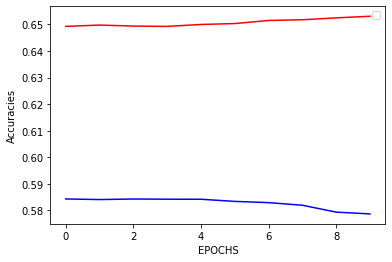

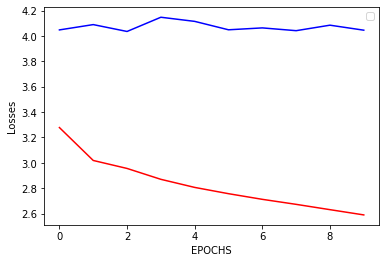

<Figure size 432x288 with 0 Axes>

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.xlabel('EPOCHS')
plt.ylabel('Accuracies')
plt.legend('Train Acc', 'Val Acc')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('EPOCHS')
plt.ylabel('Losses')
plt.legend('Train Loss', 'Val Loss')
plt.figure()

## Generate Chats by iterating over the predictor from the model and input from user

In [36]:
reverse_word_index[0] = ' '

In [37]:
sentence = SEEDER.lower()
corpus = SEEDER.lower()
new_line = False
print (sentence, end='\n')

sentence = input()
while(sentence != 'stop'):
    corpus += '\nUser: ' + sentence
    seq = tokenizer.texts_to_sequences([sentence])
    seq = pad_sequences(seq, padding=PADDING, truncating=TRUNC, maxlen=INP_LEN)
    pred_seq = model.predict(seq)
    pred_seq = np.argmax(pred_seq, axis=2)
    pred_sent = [reverse_word_index[x] for x in pred_seq[0]]
    pred_sent = ' '.join(pred_sent)
    print(pred_sent)
    corpus += '\nBot: ' + pred_sent
    sentence = input()
print ("Bye, See ya later!!!")


hi
hi
            ðÿ˜‚ðÿ˜‚ðÿ˜‚
you smiling?
             
dont know what to say
             
u r a quite person
             
tu kuch bolega bhi
             
ni bolega
             
tujhe or sikhana padega
      and to or hai
stop
Bye, See ya later!!!


## Save Chats in a file

In [ ]:
timestr = time.strftime("_%Y_%m_%d_%H_%M_%S")

save_file_path += timestr + ".txt"
try:
    with open(save_file_path, 'w') as f:
        f.write(corpus)
        f.close()
except:
    print("\nWrite was Unsuccessful")